In [138]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import hmmlearn.hmm as hmm
import ruptures as rpt

In [139]:
def add_noise(data, noise_level):
    noise = noise_level * (np.random.randn(*data.shape) + 1j * np.random.randn(*data.shape))
    return data + noise

In [140]:
def compute_SV(data):
    # Compute singular values for all matrices in array1
    sv_arr = np.zeros((0, 4))
    for i, matrix in enumerate(data):
        if not np.isnan(matrix).any():
            U, s, Vt = np.linalg.svd(matrix)
            sv_arr = np.vstack([sv_arr, s])
    return sv_arr


In [141]:
def clustering_alg(data: np.ndarray, n_clusters = 2):

    data_arr = data / np.mean(np.abs(data).flatten())

    # Determine number of clusters (for example, 1 cluster per 50 samples)
    

    sv_arr = np.zeros((0, 4))

    # Compute singular values for all matrices in data_arr
    for i, matrix in enumerate(data_arr):
        if not np.isnan(matrix).any():
            U, s, Vt = np.linalg.svd(matrix)
            sv_arr = np.vstack([sv_arr, s])

    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    #scale and normalise sv_arr to sam scale
    sv_arr_scaled = (np.log(1+sv_arr) - np.mean(np.log(1+sv_arr), axis=0)) / np.std(np.log(1+sv_arr), axis=0)


    kmeans.fit(sv_arr_scaled)
    return kmeans.labels_, kmeans.cluster_centers_

In [142]:
# Buggy not working produces naans
def regularize_data(data):
    return data / np.mean(np.abs(data).flatten())

In [143]:
def plot_SV(sv_data, labels = None):
    if labels is None:
        labels = np.zeros(sv_data.shape[0], dtype=int)
        
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
    axes = axes.ravel()
    for col in range(4):
        ax = axes[col]
        for label in np.unique(labels):
            idx = labels == label
            ax.semilogy(np.where(idx)[0], sv_data[idx, col], '.', label=f'Cluster {label}', alpha=0.6, markersize=4)
        ax.set_title(f'Singular Value {col+1}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Sample Index', fontsize=10)
        ax.set_ylabel('Singular Value', fontsize=10)
        ax.grid(True, which='both', ls='--', alpha=0.3)
        ax.legend(loc='best', fontsize=9)
    
    plt.tight_layout()
    plt.show()

In [144]:
def plot_Capacity(capacity_data, labels = None):
    if labels is None:
        labels = np.zeros(capacity_data.shape[0], dtype=int)
    for label in np.unique(labels):
        idx = labels == label
        plt.plot(np.where(idx)[0], (capacity_data[idx]), '.', label=f'Cluster {label}')
    plt.legend()
    plt.show()


In [145]:
def capacity_from_Hmatrix(H: np.ndarray, signal_to_noise_ratio: float) -> float:
    """Calculate channel capacity from channel matrix H.

    Args:
        H (np.ndarray): Channel matrix.
        signal_to_noise_ratio (float): Signal-to-noise ratio.

    Returns:
        float: Estimated channel capacity.
    """
    N_t = 4
    return np.log2(np.linalg.det(np.eye(H.shape[0]) + (signal_to_noise_ratio)/N_t * H @ H.conj().T))

In [146]:
def capacity_Vector(H_matrices):
    capacity_arr = np.zeros(len(H_matrices))
    for i, matrix in enumerate(H_matrices):
        if not np.isnan(matrix).any():
            cap = capacity_from_Hmatrix(H_matrices[i], 10)
            capacity_arr[i] = cap
    return capacity_arr

In [147]:
def hmm_clustering(sv_data, n_states=2):
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100)
    model.fit(sv_data)
    hidden_states = model.predict(sv_data)
    return hidden_states

In [148]:
def change_point_detection(sv_data, model = "rbf" , pen=10):
    algo = rpt.Pelt(model=model).fit(sv_data)
    result = algo.predict(pen=pen)

    algo = rpt.KernelCPD(kernel="linear", min_size=20).fit(sv_data)
    result = algo.predict(n_bkps=5)

    #return clusters based on change points
    clusters = np.zeros(sv_data.shape[0], dtype=int)
    for i in range(1, len(result)):
        clusters[result[i-1]:result[i]] = i - 1

    return clusters

## Actual clustering

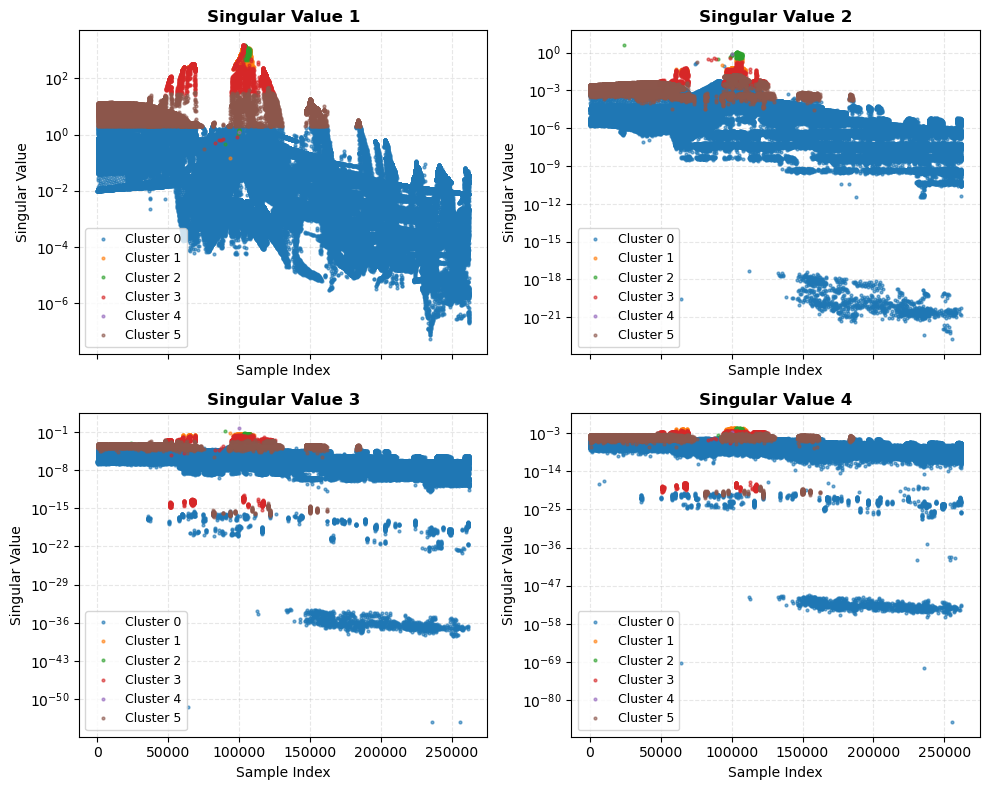

/opt/homebrew/anaconda3/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/anaconda3/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/var/folders/x1/5cmyq_7s0lb_2lw16w_7g5_r0000gn/T/ipykernel_70344/3980399525.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  capacity_arr[i] = cap


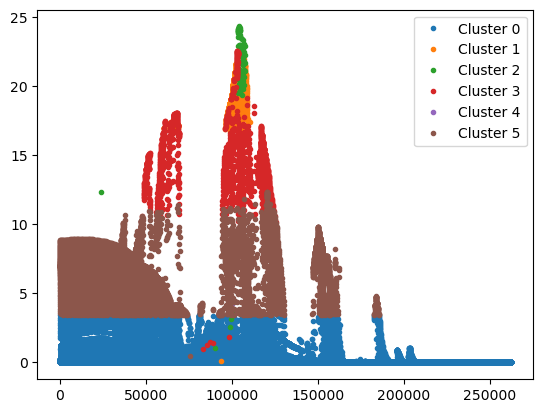

In [149]:
data = np.load('0_5_60.npz')
H_matrices = data['matrices']

H_matrices[np.isnan(H_matrices).any(axis=(1,2))] = np.zeros_like(H_matrices[np.isnan(H_matrices).any(axis=(1,2))])
H_matrices = H_matrices[:512*512]
H_matrices = regularize_data(H_matrices)
H_matrices = add_noise(H_matrices, noise_level=0)
sv_data = compute_SV(H_matrices)
labels, centers = clustering_alg(H_matrices, n_clusters=6)
#labels = hmm_clustering(np.log2(sv_data[:,0]**2).reshape(-1, 1), n_states=5)
#labels = change_point_detection(np.log2(sv_data[:,0]**2).reshape(-1, 1), model="rbf", pen=25)
plot_SV(sv_data, labels)
capacity_data = capacity_Vector(H_matrices)
plot_Capacity(capacity_data, labels)

#for i in range(10):
#    sv_data = compute_SV(H_matrices)
#    labels = hmm_clustering(sv_data, n_states=5)
#    plot_SV(sv_data, labels)
#    capacity_data = capacity_Vector(H_matrices)
#    plot_Capacity(capacity_data, labels)
#    print(f'Original number of samples: {H_matrices.shape[0]}')
#    H_matrices = H_matrices[labels != 1]
#    print(f'Number of samples after cleaning: {H_matrices.shape[0]}')

/var/folders/x1/5cmyq_7s0lb_2lw16w_7g5_r0000gn/T/ipykernel_70344/3707701078.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', fontsize=9)


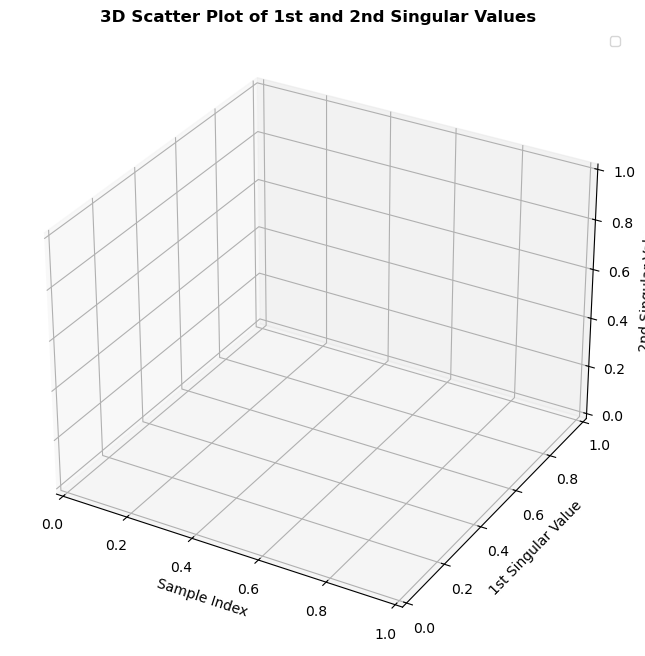

IndexError: boolean index did not match indexed array along axis 0; size of axis is 262144 but size of corresponding boolean axis is 261267

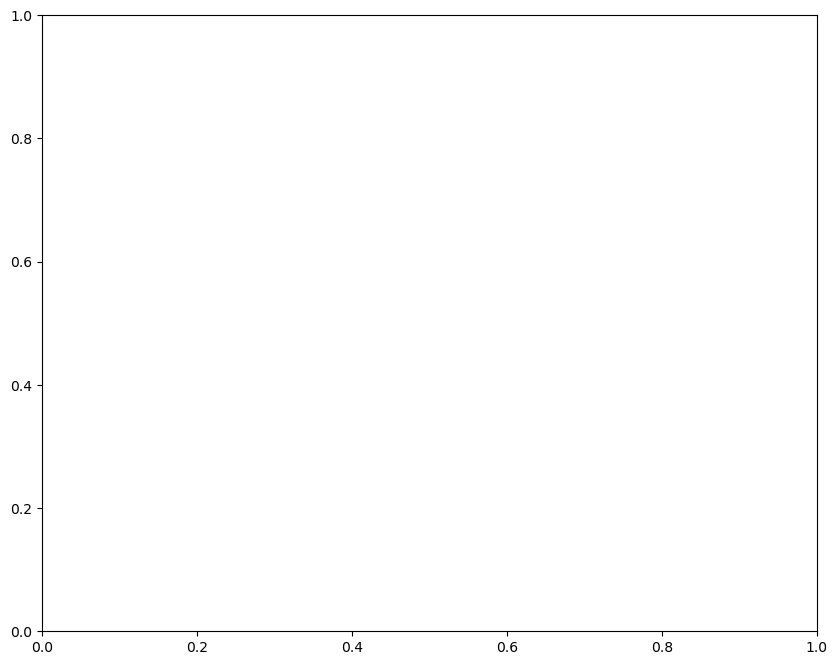

In [157]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

#for label in np.unique(labels):
#    idx = labels == label
#    ax.scatter(np.arange(len(sv_data))[idx],np.log2(1+sv_data[idx, 0]**2), np.log2(1+sv_data[idx, 1]**2), 
#               label=f'Cluster {label}', alpha=0.6, s=20)

ax.set_ylabel('1st Singular Value', fontsize=10)
ax.set_zlabel('2nd Singular Value', fontsize=10)
ax.set_xlabel('Sample Index', fontsize=10)
ax.set_title('3D Scatter Plot of 1st and 2nd Singular Values', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
plt.show()

sv_arr_scaled = (np.log(1+sv_data) - np.mean(np.log(1+sv_data), axis=0)) / np.std(np.log(1+sv_data), axis=0)



fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
# plot labels only for existing data points in sv_arr_scaled
valid_indices = ~np.isnan(sv_arr_scaled).any(axis=1)
for label in np.unique(labels):
    idx = labels == label
    if not np.isnan(sv_arr_scaled[idx]).any():
        ax.scatter(np.log(1+sv_data[idx, 0]) - np.mean(np.log(1+sv_data[:, 0]))/ np.std(np.log(1+sv_data[:, 0])), np.log(1+sv_data[idx, 1]) - np.mean(np.log(1+sv_data[:, 1]))/ np.std(np.log(1+sv_data[:, 1])),
               label=f'Cluster {label}', alpha=0.6, s=20)
plt.show()


Original number of samples: 262144
Number of samples after cleaning: 261267


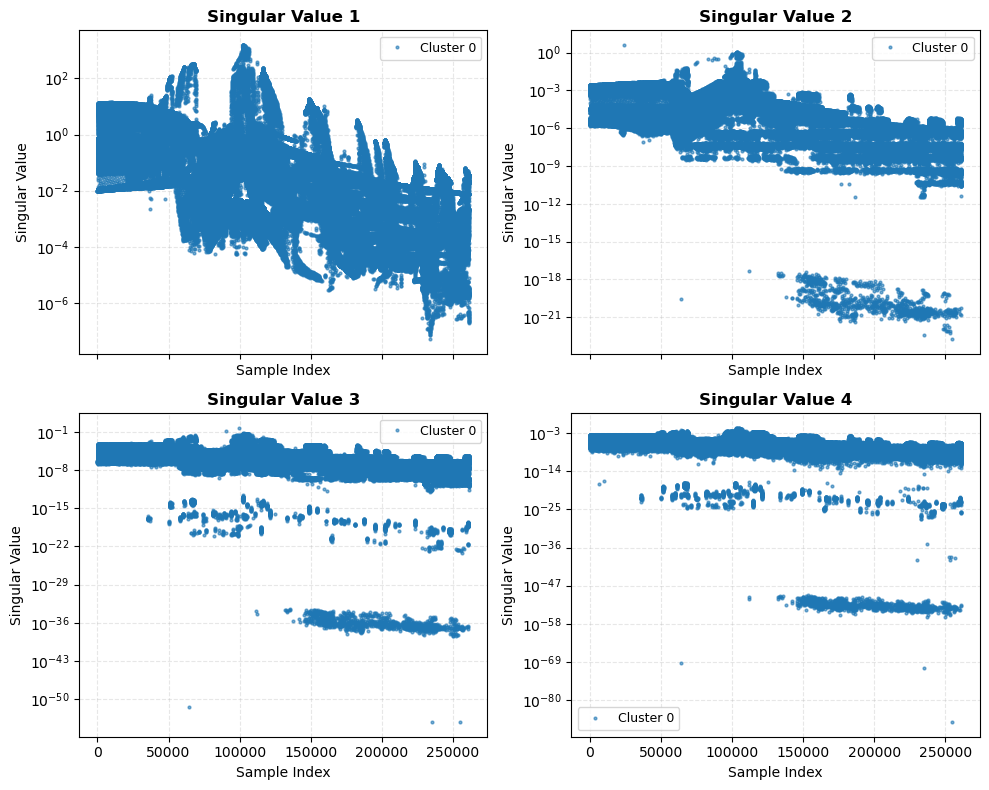

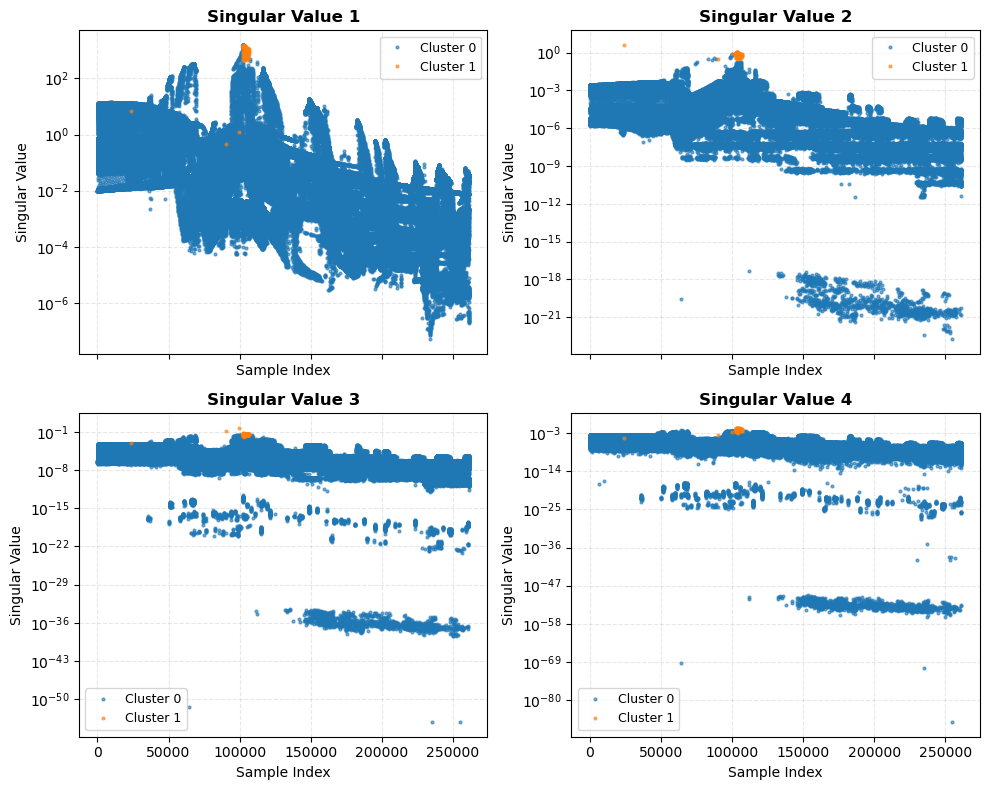

/opt/homebrew/anaconda3/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/anaconda3/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/var/folders/x1/5cmyq_7s0lb_2lw16w_7g5_r0000gn/T/ipykernel_70344/3980399525.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  capacity_arr[i] = cap


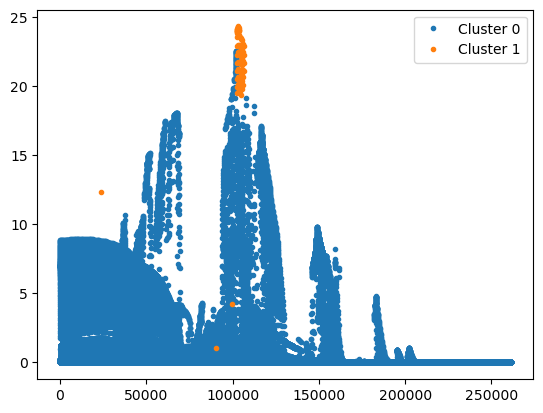

In [151]:
# remove all samples belonging to cluster 1
cleaned_matrices = H_matrices[labels != 1]
print(f'Original number of samples: {H_matrices.shape[0]}')
print(f'Number of samples after cleaning: {cleaned_matrices.shape[0]}')

sv_arr = compute_SV(cleaned_matrices)

plot_SV(sv_arr)

labels, centers = clustering_alg(cleaned_matrices, n_clusters=2)
plot_SV(sv_arr, labels)

capacities = capacity_Vector(cleaned_matrices)
plot_Capacity(capacities, labels)



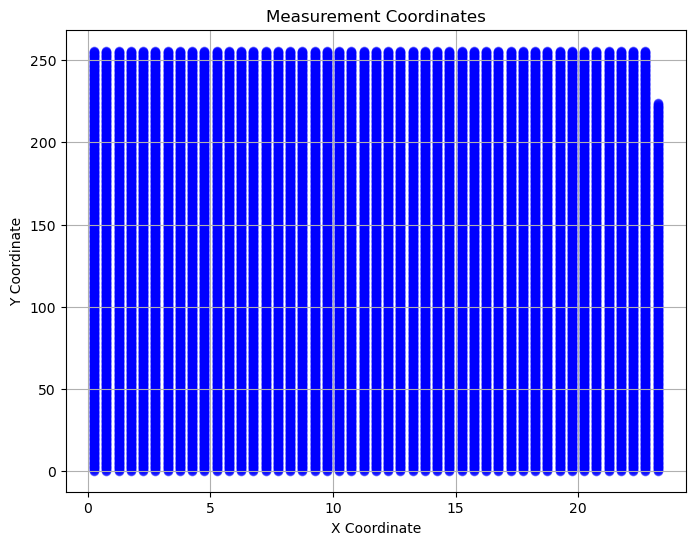

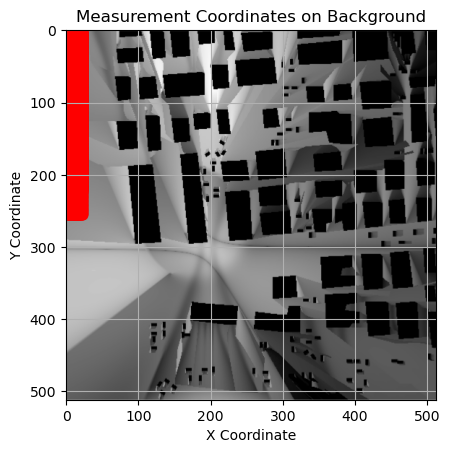

In [152]:
#plot the coordinates of the measurements extrated from data
coordinates = data['coords'][:24000]
plt.figure(figsize=(8, 6))
plt.scatter(coordinates[:, 0], coordinates[:, 1], c='blue', alpha=0.5)
plt.title('Measurement Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()




#load image.png and resize to 512x512 for background
import cv2
background = cv2.imread('image.png')
background = cv2.resize(background, (512, 512)) # Resize to 512x512

plt.imshow(background)
plt.scatter(coordinates[:, 0], coordinates[:, 1], c='red', alpha=0.5)
plt.title('Measurement Coordinates on Background')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()